✅ Data loaded and preprocessed successfully.
✅ Created lag features for past 7 days.
✅ Data split into training and testing sets.
✅ Random Forest models trained successfully.

📊 MODEL EVALUATION RESULTS
------------------------------------
🌡️ Temperature Model: MAE = 0.51, R² = 0.975
💧 Humidity Model:    MAE = 1.14, R² = 0.993


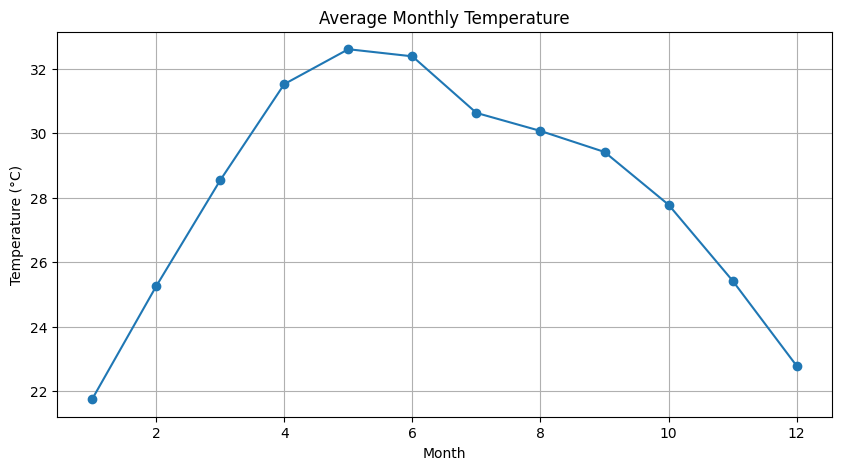


📅 Predicted Temperatures:
Day 15: 30.74 °C
Day 16: 30.74 °C
Day 17: 30.74 °C
Day 18: 30.74 °C
Day 19: 30.74 °C
Day 20: 30.74 °C
Day 21: 30.74 °C


In [2]:
# =====================================================
# 🌦️ WEATHER MODEL PIPELINE (Class-Based)
# =====================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from datetime import timedelta


class WeatherModel:
    """
    A complete pipeline for training and predicting temperature
    and humidity using Random Forest regression on weather data.
    """

    def __init__(self, file_path):
        """
        Initialize the WeatherModel with dataset path.
        """
        self.file_path = file_path
        self.weather_data = None
        self.rf_temp = None
        self.rf_hum = None
        self.X = None
        self.y_temp = None
        self.y_hum = None
        self.X_train = None
        self.X_test = None
        self.y_temp_train = None
        self.y_temp_test = None
        self.y_hum_train = None
        self.y_hum_test = None

    # =====================================================
    # 📂 Load and preprocess data
    # =====================================================
    def load_data(self):
        """Load CSV and perform datetime conversion and sorting."""
        self.weather_data = pd.read_csv(self.file_path)
        self.weather_data['DATETIME'] = pd.to_datetime(self.weather_data['DATETIME'])
        self.weather_data = self.weather_data.sort_values(by='DATETIME')
        self.weather_data['date'] = self.weather_data['DATETIME'].dt.date
        self.weather_data['month'] = self.weather_data['DATETIME'].dt.month
        self.weather_data['year'] = self.weather_data['DATETIME'].dt.year
        self.weather_data['day'] = self.weather_data['DATETIME'].dt.day
        print("✅ Data loaded and preprocessed successfully.")

    # =====================================================
    # 🔁 Create lag features for time-series modeling
    # =====================================================
    def create_lag_features(self, lags=7):
        """Create lagged temperature and humidity features."""
        for lag in range(1, lags + 1):
            self.weather_data[f'temp_lag_{lag}'] = self.weather_data['TEMPERATURE'].shift(lag)
            self.weather_data[f'hum_lag_{lag}'] = self.weather_data['HUMIDITY'].shift(lag)
        self.weather_data.dropna(inplace=True)
        print(f"✅ Created lag features for past {lags} days.")

    # =====================================================
    # ✂️ Split the data into train/test sets
    # =====================================================
    def split_data(self, test_size=0.2):
        """Prepare features and split into training/testing sets."""
        feature_cols = [col for col in self.weather_data.columns if 'lag' in col]
        self.X = self.weather_data[feature_cols]
        self.y_temp = self.weather_data['TEMPERATURE']
        self.y_hum = self.weather_data['HUMIDITY']

        self.X_train, self.X_test, self.y_temp_train, self.y_temp_test = train_test_split(
            self.X, self.y_temp, test_size=test_size, shuffle=False
        )
        _, _, self.y_hum_train, self.y_hum_test = train_test_split(
            self.X, self.y_hum, test_size=test_size, shuffle=False
        )
        print("✅ Data split into training and testing sets.")

    # =====================================================
    # 🧠 Train Random Forest models for temperature & humidity
    # =====================================================
    def train_models(self):
        """Train Random Forest regressors for both temperature and humidity."""
        self.rf_temp = RandomForestRegressor(n_estimators=100, random_state=42)
        self.rf_hum = RandomForestRegressor(n_estimators=100, random_state=42)

        self.rf_temp.fit(self.X_train, self.y_temp_train)
        self.rf_hum.fit(self.X_train, self.y_hum_train)
        print("✅ Random Forest models trained successfully.")

    # =====================================================
    # 🧮 Evaluate model performance
    # =====================================================
    def evaluate_models(self):
        """Evaluate trained models on the test data."""
        y_temp_pred = self.rf_temp.predict(self.X_test)
        y_hum_pred = self.rf_hum.predict(self.X_test)

        temp_mae = mean_absolute_error(self.y_temp_test, y_temp_pred)
        temp_r2 = r2_score(self.y_temp_test, y_temp_pred)
        hum_mae = mean_absolute_error(self.y_hum_test, y_hum_pred)
        hum_r2 = r2_score(self.y_hum_test, y_hum_pred)

        print("\n📊 MODEL EVALUATION RESULTS")
        print("------------------------------------")
        print(f"🌡️ Temperature Model: MAE = {temp_mae:.2f}, R² = {temp_r2:.3f}")
        print(f"💧 Humidity Model:    MAE = {hum_mae:.2f}, R² = {hum_r2:.3f}")

        return {
            'temp_mae': temp_mae,
            'temp_r2': temp_r2,
            'hum_mae': hum_mae,
            'hum_r2': hum_r2
        }

    # =====================================================
    # 🔮 Predict temperature for a given future week
    # =====================================================
    def predict_future_week(self, month, start_day):
        """
        Predict temperatures for a week of a given month.

        Args:
            month (int): Month number (1–12)
            start_day (int): Starting day of the week
        """
        days = range(start_day, start_day + 7)
        avg_temp = self.weather_data[self.weather_data['month'] == month]['TEMPERATURE'].mean()
        avg_hum = self.weather_data[self.weather_data['month'] == month]['HUMIDITY'].mean()

        # Construct week features matching training columns
        week_features = pd.DataFrame({
            **{f'temp_lag_{lag}': [avg_temp]*7 for lag in range(1, 8)},
            **{f'hum_lag_{lag}': [avg_hum]*7 for lag in range(1, 8)},
        })

        # Ensure column order consistency
        week_features = week_features[self.X.columns]

        # Predict temperatures
        predictions = self.rf_temp.predict(week_features)
        print("\n📅 Predicted Temperatures:")
        for d, pred in zip(days, predictions):
            print(f"Day {d}: {pred:.2f} °C")
        return predictions

    # =====================================================
    # 📈 Optional visualization
    # =====================================================
    def plot_monthly_avg(self):
        """Plot average monthly temperature trend."""
        monthly_avg = self.weather_data.groupby('month')['TEMPERATURE'].mean().reset_index()
        plt.figure(figsize=(10, 5))
        plt.plot(monthly_avg['month'], monthly_avg['TEMPERATURE'], marker='o')
        plt.title('Average Monthly Temperature')
        plt.xlabel('Month')
        plt.ylabel('Temperature (°C)')
        plt.grid(True)
        plt.show()


# =====================================================
# 🚀 Example Usage
# =====================================================
if __name__ == "__main__":
    model = WeatherModel('/content/drive/MyDrive/EE960-AIoT/Temp_and_humidity_dataset.csv')

    model.load_data()
    model.create_lag_features()
    model.split_data()
    model.train_models()
    model.evaluate_models()
    model.plot_monthly_avg()
    model.predict_future_week(month=7, start_day=15)
